In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_38544/3501765376.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


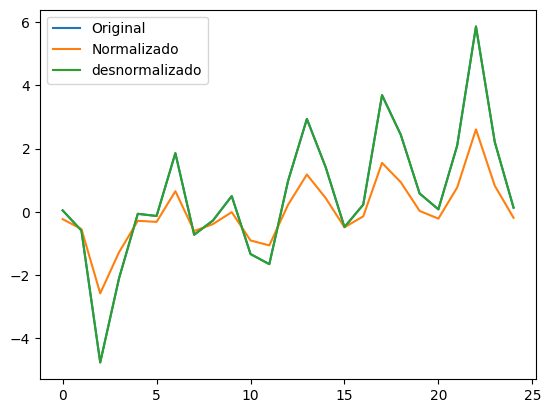

StandardScaler()

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()
input_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)

def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    denorm = out_scaler.inverse_transform(norm)
    plt.plot(denorm, label='desnormalizado')
    plt.legend()
    plt.show()

def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)

_input, _output = split_df(df_25)
input_scaler.fit(_input)        

In [3]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-19 19:57:16.783347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 19:57:16.783413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 19:57:16.785087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 19:57:16.794847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 19:57:18.099660: W tensorflow/compiler/tf2

In [19]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 
import plotly.figure_factory as ff
import plotly.offline as py
from scipy.spatial import Delaunay
import plotly.graph_objs as go
import os


class Rebuild:
    def __init__(self):
        self.df = pd.read_excel(f"../../better_results.xlsx")        
        self.sup_input, self.sup_output = split_df(df_1000_norm)

    def LoadModelWeights(self, model, fileName):        
        path = f"../models/{fileName}.keras"
        model.load_weights(path)

    def LoadPrevDataset(self, fileName):
        fileName = fileName.replace("model", "dataset")
        pos = fileName.rfind("_")
        path = f"../dataset/{fileName[:pos]}.pkl" 
        with open(path, 'rb') as f:
            _data, _train, _vt, _val, _test = pickle.load(f)
        self._data, self._train, self._vt, self._val, self._test = _data, _train, _vt, _val, _test    
    
    def setArchitecture(self, _hidden_sizes, _pg, _lr):
        shuffler = ShuffleArchitecture(input_size = 2,
                                    hidden_sizes = _hidden_sizes,
                                    output_size = 1,
                                    act_h = 'tanh',
                                    act_o = 'linear',
                                    param_reg = _pg)
        shuffler.set_architecture()
        return(shuffler.create_model(_lr))            

    def getArchitecture(self, architecture):
        hidden_size = [int(x) for x in architecture.split("[")[1].split("]")[0].split(", ")]
        regularizer = float(architecture.split("regularizer=")[1].split(",")[0])
        learning_rate = float(architecture.split("learning_rate=")[1])
        return hidden_size, regularizer, learning_rate

    def PlotResults(self, original_values, predicted_values):
        titles = ['Original vs. Preditos (Completo)',
                    'Original vs. Preditos (Teste)',
                    'Original vs. Preditos (Validação)',
                    'Original vs. Preditos (Validação e Teste)']
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        for i, ax in enumerate(axes.flat):
            ax.plot(original_values[i], label='Original')
            ax.plot(predicted_values[i], label='Preditos')
            ax.set_title(titles[i])
            ax.legend()
        plt.tight_layout()
        plt.show()


    def predictResults(self, idx=-1):
        pred = self.lm_model.predict(self._data[0]).flatten()
        test_pred = self.lm_model.predict(self._test[0]).flatten()
        val_pred = self.lm_model.predict(self._val[0]).flatten()
        vt_pred = self.lm_model.predict(self._vt[0]).flatten()
        sup_pred = self.lm_model.predict(self.sup_input).flatten()

        # Calculando as metricas com a saida desnormalizada
        pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
        test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
        val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
        vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
        sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

        out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
        test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
        val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
        vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))
        sup_denorm = out_scaler.inverse_transform(self.sup_output.reshape(-1, 1))

        original_values = [out_denorm, test_denorm, val_denorm, vt_denorm, sup_denorm]
        predicted_values = [pred_denorm, test_pred_denorm, val_pred_denorm, vt_pred_denorm, sup_pred_denorm]

        if (idx != -1):
            self.RecalcMetrics(idx,
                                out_denorm, test_denorm, val_denorm, vt_denorm, sup_denorm,
                                pred_denorm, test_pred_denorm, val_pred_denorm, vt_pred_denorm, sup_pred_denorm)            
        return (original_values, predicted_values)

    def rebuildFullNet(self, model):
        for file_model, architecture in zip(self.df["model"], self.df["Architecture"]):
            if model == file_model:
                hidden_size, regularizer, learning_rate = self.getArchitecture(architecture)
                self.lm_model = self.setArchitecture(hidden_size, regularizer, learning_rate)
                self.LoadModelWeights(self.lm_model, file_model)
                self.LoadPrevDataset(file_model)
                original_values, predicted_values = self.predictResults()
                self.PlotResults(original_values, predicted_values)

    def create_dataset(self, input, output):
        input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
        output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
        dataset = tf.data.Dataset.from_tensor_slices((input, output))
        dataset = dataset.shuffle(len(input))
        dataset = dataset.batch(1000).cache()
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return (dataset, input, output)

    def LoadNewDataset(self):
        x = np.linspace(-2, 2, 4)
        y = np.linspace(-2, 2, 4)
        x, y = np.meshgrid(x, y)
        z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
        x = x.flatten()
        y = y.flatten()
        z = z.flatten()
        input = np.vstack([x,y]).T
        output = np.array(z)
        dataset = pd.DataFrame(input, columns=['x', 'y'])
        dataset['z'] = output
       # dataset, input, output = self.create_dataset(input, output)
        #dataset= pd.DataFrame(input,output)
        return (input, dataset)
    

    def mean_std(self, df):
        df_out = df.iloc[:, 2:]
        print(df)
        mean = df_out.mean(axis=1)
        std = df_out.std(axis=1)
        df["media"] = mean
        df["desvio padrao"] = std
        display(df)
        df.to_excel('../../results.xlsx', index=False)

    def TestNewData(self):
        input, df = self.LoadNewDataset()
        for file_model, architecture in zip(self.df["model"], self.df["Architecture"]):
            hidden_size, regularizer, learning_rate = self.getArchitecture(architecture)
            self.lm_model = self.setArchitecture(hidden_size, regularizer, learning_rate)
            self.LoadModelWeights(self.lm_model, file_model)
            pred = self.lm_model.predict(input).flatten()
            pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
            df[file_model] = pred_denorm
        self.mean_std(df)
        df.to_excel
            
                


In [20]:
Rebuilder = Rebuild()
Rebuilder.TestNewData()

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step
           x         y         z  model_38_9_24  model_38_9_23  model_38_9_22  \
0  -2.000000 -2.000000  0.046835      -0.885013      -0.884988      -0.884960   
1  -0.666667 -2.000000 -1.816920      -2.825458      -2.824964      -2.824417   
2   0.666667 -2.000000 -3.660577      -4.591130      -4.593125      -4.595345   
3   2.000000 -2.000000 -0.061640       0.105663       0.105882       0.106125   
4  -2.000000 -0.666667 -0.544088      -0.791118      -0.791318      -0.791541   
5  -0.666667 -0.666667  3.378684       1.894207       1.894252       1.894302   
6   0.666667 -0.666667  0.306541      -0.239280      -0.239873      -0.240532   
7   2.000000 -0.666667  0.926193       1.336311       1.336369       1.336434   
8  -2.000000  0.666667 -0.924929      -0.863812      -0.864468      -0.865198   
9  -0.666667  0.666667  0.012390       0.239889       0.239684       0.239457   
10  0.666667  0.666667  1.211343       2.690515       2.6

,x,y,z,model_38_9_24,model_38_9_23,model_38_9_22,model_38_9_21,model_38_9_20,model_38_9_19,model_38_9_18,...,model_38_8_17,model_38_8_18,model_38_8_19,model_38_8_20,model_38_8_21,model_38_8_22,model_38_8_23,model_38_8_24,media,desvio padrao
0,-2.000000,-2.000000,0.046835,-0.885013,-0.884988,-0.884960,-0.884928,-0.884894,-0.884855,-0.884810,...,-0.882034,-0.882042,-0.882048,-0.882054,-0.882059,-0.882065,-0.882070,-0.882074,-0.864890,0.127689
1,-0.666667,-2.000000,-1.816920,-2.825458,-2.824964,-2.824417,-2.823808,-2.823131,-2.822381,-2.821548,...,-2.768099,-2.768369,-2.768612,-2.768830,-2.769026,-2.769203,-2.769363,-2.769506,-2.767374,0.135466
2,0.666667,-2.000000,-3.660577,-4.591130,-4.593125,-4.595345,-4.597808,-4.600543,-4.603579,-4.606953,...,-4.815348,-4.815850,-4.816301,-4.816709,-4.817074,-4.817403,-4.817701,-4.817966,-4.711711,0.170362
3,2.000000,-2.000000,-0.061640,0.105663,0.105882,0.106125,0.106395,0.106695,0.107029,0.107399,...,0.131837,0.131791,0.131750,0.131712,0.131679,0.131647,0.131620,0.131595,0.122694,0.033157
4,-2.000000,-0.666667,-0.544088,-0.791118,-0.791318,-0.791541,-0.791787,-0.792061,-0.792365,-0.792702,...,-0.812227,-0.812460,-0.812670,-0.812859,-0.813029,-0.813182,-0.813320,-0.813444,-0.798764,0.036454
5,-0.666667,-0.666667,3.378684,1.894207,1.894252,1.894302,1.894357,1.894417,1.894485,1.894560,...,1.898751,1.898757,1.898763,1.898768,1.898772,1.898775,1.898777,1.898781,1.925157,0.203505
6,0.666667,-0.666667,0.306541,-0.239280,-0.239873,-0.240532,-0.241264,-0.242078,-0.242983,-0.243989,...,-0.308947,-0.309129,-0.309291,-0.309439,-0.309571,-0.309690,-0.309798,-0.309894,-0.270467,0.085325
7,2.000000,-0.666667,0.926193,1.336311,1.336369,1.336434,1.336506,1.336584,1.336672,1.336770,...,1.342642,1.342706,1.342764,1.342815,1.342861,1.342904,1.342941,1.342976,1.329767,0.057920
8,-2.000000,0.666667,-0.924929,-0.863812,-0.864468,-0.865198,-0.866008,-0.866909,-0.867909,-0.869020,...,-0.939357,-0.939423,-0.939481,-0.939532,-0.939579,-0.939620,-0.939660,-0.939693,-0.910654,0.030575
9,-0.666667,0.666667,0.012390,0.239889,0.239684,0.239457,0.239205,0.238925,0.238613,0.238267,...,0.216441,0.216408,0.216380,0.216356,0.216332,0.216311,0.216292,0.216276,0.221962,0.031109
